# 1. Introdution

## 1.1 Description of the Problem and Discussion of the Background

Prospects of a Restaurant, where to install and which kind of food sell in Santiago City, Chile.
This is an analysis for an entrepreneur who asked which neighborhood in Santiago would be the better to install a Gourmet Restaurant and what kind of competence can find around this place. 

To answer the requirement this project begin with an analysis of Santiago’s Neighborhoods.

Santiago is the capital city of Chile, a country located in Latin America. Chile has 15 states, and Santiago is located in the “Metropolitan Region” State, this state has 7MM “habitantes” and represents 50% of Chile polulation. Each State in Chile is divided in “Comunas”, Santiago city that contains many “comunas”, this Project will analyze this “comunas” and will try to define where is the best comuna to install a Gourmet restaurant, but also which kind of restaurant it can be found in those comunas, and what are their main venues.

## 1.2 Target Audience

•	Entrepreneurs who are interested in start a Gourmet Restaurant business in Comunas in Santiago de Chile.

•	People who would like to live and know which kind places can be found on Comunas that are described in this project.

•	Data Scientist who would like to extend this analysis to different Comunas in Santiago or different states either in a demographic or business approach

# 2. Initial Data Adquisition

2.1. Define and Get Comunas Names to work with from Wikipedia
2.2. Processing the Information From Wiki To Make Necessary Lists
2.3. Get the Coordinates of the Comunas

The data to solve the problem in first section will be provided by

1.- Wikipedia to get Comuna Data

2.- Geolocator to get Comuna Latitude and Longitude

3.- Foursquare API: to get venues of each Comuna.
•	Number and Kind of restaurant per Comuna
•	Venues more frecuent per Comuna


In [1]:
#Import Relevant Libraries

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium==0.5.0
import folium # map rendering library

from bs4 import BeautifulSoup

     |████████████████████████████████| 81kB 9.3MB/s  eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium


## 2.1 Get Comuna Data

### 2.1.1 Get Social info About Comunas

In [2]:
#Get social data from Wikipedia
wikipedia_url = "https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile"
source = requests.get(wikipedia_url).text

In [3]:
#Get website in text
soup = BeautifulSoup(source, 'html5lib')

In [4]:
tables = soup.find_all('table', {'class':'wikitable sortable'})
table_1=tables[0]

In [5]:
#dataframe with column names translated to english
column_names = ['Comuna','Orientation','Population_2017', 'Houses', 'Population_density', 'Population_growth', 'ICVU_index', 'Poberty']
df_wiki = pd.DataFrame(columns = column_names)

In [6]:
#Each row (tr) in Table has 8 values (td)
for tr_cell in table_1.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==8:
        df_wiki.loc[len(df_wiki)] = row_data

In [7]:
df_wiki.head()

,Comuna,Orientation,Population_2017,Houses,Population_density,Population_growth,ICVU_index,Poberty
0,Cerrillos,surponiente,80832,19811,4329.08,12.9%,47.82 (74),19.7
1,Cerro Navia,norponiente,132622,35277,13482.91,-10.7%,42.42 (92),35.6
2,Conchalí,norte,126955,32609,12070.29,-4.4%,46.52 (84),21.6
3,El Bosque,sur,162505,42808,12270.72,-7.3%,48.54 (70),27.0
4,Estación Central,surponiente,147041,32357,9036.31,16.6%,49.96 (64),14.5


### 2.1.2 Data modification

In [8]:
df_comunas = df_wiki

In [9]:
#Delete numbers in parenthesis in column ICVU
df_comunas['ICVU_index'] = df_comunas['ICVU_index'].str[0:5]
#drop rows from dataframe where Poberty is Empty
df_comunas = df_comunas.drop(df_comunas[df_comunas['Poberty']==''].index)
#Convert to numeric Column Poberty
df_comunas["Poberty"] = pd.to_numeric(df_comunas["Poberty"])
#replace number that has a comma
df_comunas=df_comunas.replace(to_replace ='69,09', value ='69.09')
#Convert to numeric Column ICVU
df_comunas['ICVU_index'] = pd.to_numeric(df_comunas['ICVU_index'])
df_comunas.head()

,Comuna,Orientation,Population_2017,Houses,Population_density,Population_growth,ICVU_index,Poberty
0,Cerrillos,surponiente,80832,19811,4329.08,12.9%,47.82,19.7
1,Cerro Navia,norponiente,132622,35277,13482.91,-10.7%,42.42,35.6
2,Conchalí,norte,126955,32609,12070.29,-4.4%,46.52,21.6
3,El Bosque,sur,162505,42808,12270.72,-7.3%,48.54,27.0
4,Estación Central,surponiente,147041,32357,9036.31,16.6%,49.96,14.5


In [10]:
#Drop Columns to keep only Nombre and Superficie KM2
df_comunas=df_comunas.drop(columns=['Orientation', 'Population_density'])
df_comunas.head()

,Comuna,Population_2017,Houses,Population_growth,ICVU_index,Poberty
0,Cerrillos,80832,19811,12.9%,47.82,19.7
1,Cerro Navia,132622,35277,-10.7%,42.42,35.6
2,Conchalí,126955,32609,-4.4%,46.52,21.6
3,El Bosque,162505,42808,-7.3%,48.54,27.0
4,Estación Central,147041,32357,16.6%,49.96,14.5


## 2.2 Final Comunas to work with

In [11]:
#Sort by ICVU_index
df_comunas.sort_values('ICVU_index',ascending=False,inplace=True)
df_comunas = df_comunas.reset_index()
del df_comunas['index']
df_comunas

,Comuna,Population_2017,Houses,Population_growth,ICVU_index,Poberty
0,Vitacura,85384,23878,6.2%,75.59,2.8
1,Las Condes,294838,82099,19.6%,74.54,4.8
2,La Reina,92787,25768,-3.8%,70.45,9.8
3,Lo Barnechea,105833,16124,"43,2%",69.09,17.3
4,Providencia,142079,51183,21.4%,68.79,4.6
5,Ñuñoa,208237,54692,28.2%,66.28,10.7
6,Macul,116534,29870,4.1%,61.92,17.5
7,Santiago,404495,99155,88.9%,59.27,11.6
8,San Miguel,107954,22655,38.6%,58.53,11.6
9,La Florida,366916,97137,0.6%,57.23,17.0


In [12]:
#define final Comunas to work with
df_final_comunas=df_comunas.head(8)
df_final_comunas

,Comuna,Population_2017,Houses,Population_growth,ICVU_index,Poberty
0,Vitacura,85384,23878,6.2%,75.59,2.8
1,Las Condes,294838,82099,19.6%,74.54,4.8
2,La Reina,92787,25768,-3.8%,70.45,9.8
3,Lo Barnechea,105833,16124,"43,2%",69.09,17.3
4,Providencia,142079,51183,21.4%,68.79,4.6
5,Ñuñoa,208237,54692,28.2%,66.28,10.7
6,Macul,116534,29870,4.1%,61.92,17.5
7,Santiago,404495,99155,88.9%,59.27,11.6


In [13]:
#replace Comuna name Santiago by Santiago de Chile
df_final_comunas=df_final_comunas.replace(to_replace ='Santiago', 
                 value ='Santiago de Chile')

## 2.3 Get more data for Final Comunas

As each comuna has its own size, it is necesary to get Radius for each one

In [14]:
#Get data from Wikipedia
wikipedia_url2 = "https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile"
source2 = requests.get(wikipedia_url2).text
#Get website in text
soup2 = BeautifulSoup(source2, 'html5lib')
#Get Data Table
tables2 = soup2.find_all('table', {'class':'wikitable sortable'})
table_2=tables2[0]

In [15]:
#Create a dataframe to get Comuna's areas of Wikipedia Table
column_names3 = ['Dum_1','Comuna','Dum_2', 'Dum_3', 'Dum_4', 'Square_KM2', 'Dum_5', 'Dum_6','Dum_7', 'Dum_8', 'Dum_9', 'Dum_10']
df_wiki2 = pd.DataFrame(columns = column_names3)

In [16]:
#Each row (tr) in Table has 11 values (td)
for tr_cell in table_2.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==12:
        df_wiki2.loc[len(df_wiki2)] = row_data

In [17]:
df_wiki2.head()

,Dum_1,Comuna,Dum_2,Dum_3,Dum_4,Square_KM2,Dum_5,Dum_6,Dum_7,Dum_8,Dum_9,Dum_10
0,15101,Arica,,Arica,Arica y Parinacota,4799.4,221364,0.46,38.4,Alto,"-18°27'18""","-70°17'24"""
1,15102,Camarones,,Arica,Arica y Parinacota,3927,1255,0.32,0.751,Alto,"-19°1'1.2""","-69°52'1.2"""
2,15201,Putre,,Parinacota,Arica y Parinacota,5902.5,2765,0.47,0.707,Alto,"-18°12'0""","-69°34'58.8"""
3,15202,General Lagos,,Parinacota,Arica y Parinacota,2244.4,684,0.31,0.67,Medio,"-17°39'10.8""","-69°38'6"""
4,01101,Iquique,,Iquique,Tarapacá,2242.1,191468,85.4,0.766,Alto,"-20°14'38.4""","-70°8'20.4"""


In [18]:
df_comuna_area=df_wiki2
#replace Comuna name Santiago by Santiago de Chile
df_comuna_area=df_comuna_area.replace(to_replace ='Santiago', 
                 value ='Santiago de Chile')

In [19]:
#Drop Columns to keep only Comuna Name and Square_KM2
df_comuna_area=df_comuna_area.drop(columns=['Dum_1','Dum_2', 'Dum_3', 'Dum_4', 'Dum_5', 'Dum_6','Dum_7', 'Dum_8', 'Dum_9', 'Dum_10'])
df_comuna_area.head()

,Comuna,Square_KM2
0,Arica,4799.4
1,Camarones,3927
2,Putre,5902.5
3,General Lagos,2244.4
4,Iquique,2242.1


In [20]:
df_merge1 = pd.merge(df_final_comunas, df_comuna_area, left_on='Comuna', right_on='Comuna', how='inner')
df_merge1

,Comuna,Population_2017,Houses,Population_growth,ICVU_index,Poberty,Square_KM2
0,Vitacura,85384,23878,6.2%,75.59,2.8,28.3
1,Las Condes,294838,82099,19.6%,74.54,4.8,99
2,La Reina,92787,25768,-3.8%,70.45,9.8,23
3,Lo Barnechea,105833,16124,"43,2%",69.09,17.3,1024
4,Providencia,142079,51183,21.4%,68.79,4.6,14.3
5,Ñuñoa,208237,54692,28.2%,66.28,10.7,16.9
6,Macul,116534,29870,4.1%,61.92,17.5,12.9
7,Santiago de Chile,404495,99155,88.9%,59.27,11.6,23.2


In [21]:
#Calculate Radius
df_merge1['Square_KM2'] = df_merge1['Square_KM2'].astype('float64')
df_merge1['Radius'] = df_merge1['Square_KM2']/3.1415
df_merge1['Radius'] = df_merge1['Radius']**(0.5)
df_merge1['Radius'] = df_merge1['Radius']*1000
#Convert Radius to Integer data type
df_merge1['Radius']=df_merge1['Radius'].astype('int64')
df_merge1

,Comuna,Population_2017,Houses,Population_growth,ICVU_index,Poberty,Square_KM2,Radius
0,Vitacura,85384,23878,6.2%,75.59,2.8,28.3,3001
1,Las Condes,294838,82099,19.6%,74.54,4.8,99.0,5613
2,La Reina,92787,25768,-3.8%,70.45,9.8,23.0,2705
3,Lo Barnechea,105833,16124,"43,2%",69.09,17.3,1024.0,18054
4,Providencia,142079,51183,21.4%,68.79,4.6,14.3,2133
5,Ñuñoa,208237,54692,28.2%,66.28,10.7,16.9,2319
6,Macul,116534,29870,4.1%,61.92,17.5,12.9,2026
7,Santiago de Chile,404495,99155,88.9%,59.27,11.6,23.2,2717


## 2.4 Get location data for Final Comunas

In [22]:
#Define a Dataframe to get Comuna Location
column_names2 = ['Comuna','Address','Latitude', 'Longitude']
df_comunas_location = pd.DataFrame(columns = column_names2)

In [23]:
#Getting location for each comuna
for Comuna in (df_final_comunas['Comuna']):
    address = Comuna + ", CL"
    geolocator = Nominatim(user_agent="Chile_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    df_comunas_location = df_comunas_location.append({'Comuna': Comuna,
                                    'Address': address,
                                    'Latitude': latitude,
                                    'Longitude': longitude}, ignore_index=True)

In [24]:
df_comunas_location

,Comuna,Address,Latitude,Longitude
0,Vitacura,"Vitacura, CL",-33.380206,-70.565796
1,Las Condes,"Las Condes, CL",-33.424788,-70.517498
2,La Reina,"La Reina, CL",-33.447373,-70.533412
3,Lo Barnechea,"Lo Barnechea, CL",-33.293589,-70.390355
4,Providencia,"Providencia, CL",-33.428838,-70.611337
5,Ñuñoa,"Ñuñoa, CL",-33.454330,-70.600582
6,Macul,"Macul, CL",-33.491943,-70.599732
7,Santiago de Chile,"Santiago de Chile, CL",-33.437797,-70.650445


In [25]:
#Merge and define final name
df_merge2 = pd.merge(df_merge1, df_comunas_location, on='Comuna', how='inner')
df_final=df_merge2
df_final

,Comuna,Population_2017,Houses,Population_growth,ICVU_index,Poberty,Square_KM2,Radius,Address,Latitude,Longitude
0,Vitacura,85384,23878,6.2%,75.59,2.8,28.3,3001,"Vitacura, CL",-33.380206,-70.565796
1,Las Condes,294838,82099,19.6%,74.54,4.8,99.0,5613,"Las Condes, CL",-33.424788,-70.517498
2,La Reina,92787,25768,-3.8%,70.45,9.8,23.0,2705,"La Reina, CL",-33.447373,-70.533412
3,Lo Barnechea,105833,16124,"43,2%",69.09,17.3,1024.0,18054,"Lo Barnechea, CL",-33.293589,-70.390355
4,Providencia,142079,51183,21.4%,68.79,4.6,14.3,2133,"Providencia, CL",-33.428838,-70.611337
5,Ñuñoa,208237,54692,28.2%,66.28,10.7,16.9,2319,"Ñuñoa, CL",-33.454330,-70.600582
6,Macul,116534,29870,4.1%,61.92,17.5,12.9,2026,"Macul, CL",-33.491943,-70.599732
7,Santiago de Chile,404495,99155,88.9%,59.27,11.6,23.2,2717,"Santiago de Chile, CL",-33.437797,-70.650445


In [26]:
#Some Coordenates are wrong, this step is to replace them for Comunas "Las Condes" and "Lo Barnechea"
#Lo Barnechea
df_final.iat[3,9]=-33.35
df_final.iat[3,10]=-70.51666666666667
#Las Condes
df_final.iat[1,9]=-33.4166667
df_final.iat[1,10]=-70.59999972222222
#Lo Barnechea is the Largest Comuna and that means that has the longest Radius, this make venues from different Comunas, its necessaty to modify it
#radius divided by 2
df_final.iat[3,7]=9027
df_final

,Comuna,Population_2017,Houses,Population_growth,ICVU_index,Poberty,Square_KM2,Radius,Address,Latitude,Longitude
0,Vitacura,85384,23878,6.2%,75.59,2.8,28.3,3001,"Vitacura, CL",-33.380206,-70.565796
1,Las Condes,294838,82099,19.6%,74.54,4.8,99.0,5613,"Las Condes, CL",-33.416667,-70.600000
2,La Reina,92787,25768,-3.8%,70.45,9.8,23.0,2705,"La Reina, CL",-33.447373,-70.533412
3,Lo Barnechea,105833,16124,"43,2%",69.09,17.3,1024.0,9027,"Lo Barnechea, CL",-33.350000,-70.516667
4,Providencia,142079,51183,21.4%,68.79,4.6,14.3,2133,"Providencia, CL",-33.428838,-70.611337
5,Ñuñoa,208237,54692,28.2%,66.28,10.7,16.9,2319,"Ñuñoa, CL",-33.454330,-70.600582
6,Macul,116534,29870,4.1%,61.92,17.5,12.9,2026,"Macul, CL",-33.491943,-70.599732
7,Santiago de Chile,404495,99155,88.9%,59.27,11.6,23.2,2717,"Santiago de Chile, CL",-33.437797,-70.650445


In [27]:
# get Santiago Latitude and Longitude for

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Santiago de Chile'

geolocator = Nominatim(user_agent="Chile_explorer")
location = geolocator.geocode(address)
Santiago_latitude = location.latitude
Santiago_longitude = location.longitude 

In [28]:
# Map of Final Comunas
Santiago_8Comunas = folium.Map(location=[Santiago_latitude, Santiago_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_final['Latitude'], df_final['Longitude'], 
                           df_final['Comuna']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        color='red',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(Santiago_8Comunas)

Santiago_8Comunas

# 3 Foursquare Getting venues for these comunas

In [29]:
CLIENT_ID = 'GFQGPGDXLCTPYQATFHQKDTXPPGFSEWNI5TOWUWJKXYXB4VHG' # your Foursquare ID
CLIENT_SECRET = 'YHBRDK10XUGZQTZRJ3JMDVCG4BJBEDIZIZDU12UKEUL0BL2J' # your Foursquare Secret
VERSION = '20200802'
LIMIT = 125

## 3.1 Getting Venues for each comuna

In [30]:
def getNearbyVenues(names, latitudes, longitudes, Radius):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, Radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Comuna', 
                  'Comuna Latitude', 
                  'Comuna Longitude', 
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)


In [31]:
Santiago_8_Comunas_Venues = getNearbyVenues(names=df_final['Comuna'],
                                   latitudes=df_final['Latitude'],
                                   longitudes=df_final['Longitude'],
                                   Radius=df_final['Radius']
                                  )

Vitacura
Las Condes
La Reina
Lo Barnechea
Providencia
Ñuñoa
Macul
Santiago de Chile


In [32]:
print(Santiago_8_Comunas_Venues.shape)
Santiago_8_Comunas_Venues.head(8)

(786, 7)


,Comuna,Comuna Latitude,Comuna Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
0,Vitacura,-33.380206,-70.565796,Club de Golf Sport Francés,-33.380146,-70.562518,Golf Course
1,Vitacura,-33.380206,-70.565796,Spa One & Only,-33.382544,-70.572007,Spa
2,Vitacura,-33.380206,-70.565796,Pasteleria y Heladeria - La Ermita,-33.383683,-70.573423,Ice Cream Shop
3,Vitacura,-33.380206,-70.565796,La Guapa Simona,-33.382437,-70.571933,Salon / Barbershop
4,Vitacura,-33.380206,-70.565796,La Chocolatine,-33.386412,-70.563223,Bakery
5,Vitacura,-33.380206,-70.565796,Centro Cultural Amanda,-33.387675,-70.567996,Music Venue
6,Vitacura,-33.380206,-70.565796,Starbucks,-33.387565,-70.566398,Coffee Shop
7,Vitacura,-33.380206,-70.565796,Kadó Regalos Con Sentido,-33.381331,-70.571176,Gift Shop


In [33]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

Santiago_8_Comunas_Venues_only_restaurant = Santiago_8_Comunas_Venues[Santiago_8_Comunas_Venues['Venue_Category']\
                                                          .str.contains('Restaurant')].reset_index(drop=True)
Santiago_8_Comunas_Venues_only_restaurant.index = np.arange(1, len(Santiago_8_Comunas_Venues_only_restaurant)+1)
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Santiago_8_Comunas_Venues_only_restaurant.shape)
Santiago_8_Comunas_Venues_only_restaurant.head(3)

Shape of the Data-Frame with Venue Category only Restaurant:  (160, 7)


,Comuna,Comuna Latitude,Comuna Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
1,Vitacura,-33.380206,-70.565796,Zuki Louge & Nikkei,-33.385687,-70.559630,Sushi Restaurant
2,Vitacura,-33.380206,-70.565796,BordeRío,-33.381788,-70.579756,Restaurant
3,Vitacura,-33.380206,-70.565796,Zanzibar Underground,-33.381622,-70.579251,Restaurant


In [34]:
## Show in Map the Top Rated Restaruants in the 8 Comunas

map_restaurants = folium.Map(location=[Santiago_latitude, Santiago_longitude], zoom_start=11, tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the Venues based on the 8 Comunas
Comunas = ['Vitacura', 'Las Condes', 'La Reina', 'Lo Barnechea', 'Providencia', 'Ñuñoa', 'Macul', 'Santiago de Chile']

x = np.arange(len(Comunas))

rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000', '#ffff00', '#00ffff', 'ffffff']

# add markers to the map
# markers_colors = []
for lat, lon, poi, distr in zip(Santiago_8_Comunas_Venues_only_restaurant['Venue Latitude'], 
                                  Santiago_8_Comunas_Venues_only_restaurant['Venue Longitude'], 
                                  Santiago_8_Comunas_Venues_only_restaurant['Venue_Category'], 
                                  Santiago_8_Comunas_Venues_only_restaurant['Comuna']):
    label = folium.Popup(str(poi) + ' ' + str(distr), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[Comunas.index(distr)-1],
        fill=True,
        fill_color=rainbow[Comunas.index(distr)-1],
        fill_opacity=0.3).add_to(map_restaurants)
       
map_restaurants

In [35]:
### Number of Unique Categories in the Dataframe 
print('There are {} unique categories.'.format(len(Santiago_8_Comunas_Venues['Venue_Category'].unique())))

There are 177 unique categories.


In [36]:
print (Santiago_8_Comunas_Venues['Venue_Category'].value_counts())

Coffee Shop                        40
Park                               35
Bakery                             32
Restaurant                         27
Pizza Place                        24
Café                               20
Hotel                              18
Peruvian Restaurant                17
Sandwich Place                     17
Plaza                              16
Chinese Restaurant                 14
Gym                                13
Sushi Restaurant                   13
Soccer Field                       12
Italian Restaurant                 11
Gym / Fitness Center               11
Athletics & Sports                 10
Bar                                10
Ice Cream Shop                     10
Spa                                10
Shopping Mall                       9
Seafood Restaurant                  9
Vegetarian / Vegan Restaurant       9
Playground                          8
Bookstore                           8
Scenic Lookout                      8
Yoga Studio 

In [37]:
# create a dataframe of top 10 categories
Santiago_8_Comunas_Venues_Top10 = Santiago_8_Comunas_Venues['Venue_Category'].value_counts()[0:10].to_frame(name='frequency')
Santiago_8_Comunas_Venues_Top10=Santiago_8_Comunas_Venues_Top10.reset_index()
#Santiago_8_Comunas_Venues_Top10

Santiago_8_Comunas_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Santiago_8_Comunas_Venues_Top10

,Venue_Category,Frequency
0,Coffee Shop,40
1,Park,35
2,Bakery,32
3,Restaurant,27
4,Pizza Place,24
5,Café,20
6,Hotel,18
7,Peruvian Restaurant,17
8,Sandwich Place,17
9,Plaza,16


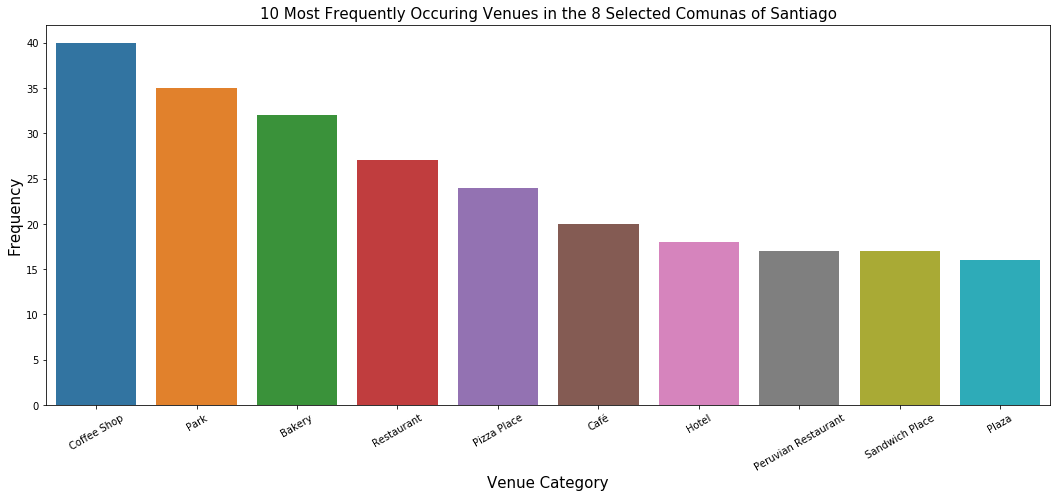

In [38]:
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Santiago_8_Comunas_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in the 8 Selected Comunas of Santiago', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

In [39]:
### Use One Hot Encoding to Get More Information about the Venue Categories 
Santiago_8_Comunas_Venues_onehot = pd.get_dummies(Santiago_8_Comunas_Venues[['Venue_Category']], prefix="", prefix_sep="")

### add district column back to dataframe
Santiago_8_Comunas_Venues_onehot['Comuna'] = Santiago_8_Comunas_Venues['Comuna'] 
### move district column to the first column
fixed_columns = [Santiago_8_Comunas_Venues_onehot.columns[-1]] + list(Santiago_8_Comunas_Venues_onehot.columns[:-1])
Santiago_8_Comunas_Venues_onehot = Santiago_8_Comunas_Venues_onehot[fixed_columns]
###Tokyo_5_Dist_Venues_onehot.head(3)

In [40]:
Santiago_8_Comunas_Venues_Grouped = Santiago_8_Comunas_Venues_onehot.groupby('Comuna').mean().reset_index()
Santiago_8_Comunas_Venues_Grouped.index = np.arange(1, len(Santiago_8_Comunas_Venues_Grouped)+1)
Santiago_8_Comunas_Venues_Grouped

,Comuna,Accessories Store,Airport,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Theme Park Ride / Attraction,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
1,La Reina,0.00,0.020833,0.010417,0.010417,0.00,0.00,0.00,0.00,0.00,...,0.00,0.010417,0.010417,0.00,0.00,0.00,0.00,0.00,0.00,0.010417
2,Las Condes,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000000,0.000000,0.02,0.00,0.00,0.01,0.01,0.01,0.000000
3,Lo Barnechea,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,...,0.01,0.000000,0.030000,0.01,0.00,0.01,0.00,0.00,0.00,0.000000
4,Macul,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,...,0.00,0.011111,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
5,Providencia,0.00,0.000000,0.000000,0.010000,0.00,0.01,0.00,0.00,0.01,...,0.00,0.000000,0.000000,0.02,0.01,0.00,0.00,0.02,0.02,0.000000
6,Santiago de Chile,0.01,0.000000,0.000000,0.000000,0.00,0.02,0.02,0.02,0.00,...,0.00,0.000000,0.000000,0.02,0.00,0.00,0.01,0.00,0.02,0.000000
7,Vitacura,0.00,0.010000,0.000000,0.000000,0.01,0.00,0.00,0.00,0.00,...,0.01,0.000000,0.010000,0.01,0.00,0.01,0.00,0.00,0.01,0.000000
8,Ñuñoa,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.01,...,0.00,0.000000,0.010000,0.01,0.00,0.00,0.01,0.01,0.02,0.000000


In [41]:
num_top_venues = 10

for places in Santiago_8_Comunas_Venues_Grouped['Comuna']:
    print("%%%%%%%%%"+places+"%%%%%%%%")
    temp = Santiago_8_Comunas_Venues_Grouped[Santiago_8_Comunas_Venues_Grouped['Comuna'] == places].T.reset_index()
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

%%%%%%%%%La Reina%%%%%%%%
              Venue  Freq
0      Soccer Field  0.06
1              Park  0.05
2        Restaurant  0.05
3       Pizza Place  0.04
4         Pet Store  0.03
5             Plaza  0.03
6       Coffee Shop  0.03
7    Farmers Market  0.03
8    Sandwich Place  0.02
9  Sushi Restaurant  0.02


%%%%%%%%%Las Condes%%%%%%%%
                 Venue  Freq
0                 Park  0.09
1               Bakery  0.06
2          Coffee Shop  0.05
3                Hotel  0.05
4  Peruvian Restaurant  0.04
5       Scenic Lookout  0.03
6       Ice Cream Shop  0.03
7          Pizza Place  0.02
8                Plaza  0.02
9           Playground  0.02


%%%%%%%%%Lo Barnechea%%%%%%%%
                  Venue  Freq
0                Bakery  0.06
1           Coffee Shop  0.05
2         Shopping Mall  0.04
3                  Park  0.04
4           Supermarket  0.04
5       Motorcycle Shop  0.04
6                   Gym  0.04
7    Athletics & Sports  0.03
8  Gym / Fitness Center  0.03
9      

In [61]:
## Define a Function to select the top 10 rows (According to the Values) 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Comuna']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Comunas_top10_venues_sorted = pd.DataFrame(columns=columns)
Comunas_top10_venues_sorted['Comuna'] = Santiago_8_Comunas_Venues_Grouped['Comuna']

for ind in np.arange(Santiago_8_Comunas_Venues_Grouped.shape[0]):
    Comunas_top10_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Santiago_8_Comunas_Venues_Grouped.iloc[ind, :], num_top_venues)

    
Comunas_top10_venues_sorted.index = np.arange(1, len(Comunas_top10_venues_sorted)+1)
Comunas_top10_venues_sorted.head(8)

,Comuna,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,La Reina,Soccer Field,Restaurant,Park,Pizza Place,Coffee Shop,Plaza,Pet Store,Farmers Market,Sushi Restaurant,Racetrack
2,Las Condes,Park,Bakery,Coffee Shop,Hotel,Peruvian Restaurant,Scenic Lookout,Ice Cream Shop,Japanese Restaurant,Mediterranean Restaurant,Liquor Store
3,Lo Barnechea,Bakery,Coffee Shop,Shopping Mall,Gym,Park,Supermarket,Motorcycle Shop,Trail,Golf Course,Gym / Fitness Center
4,Macul,Chinese Restaurant,Restaurant,Soccer Field,Pharmacy,Hot Dog Joint,Sushi Restaurant,Pizza Place,Sandwich Place,Food Truck,BBQ Joint
5,Providencia,Coffee Shop,Hotel,Park,French Restaurant,Indian Restaurant,Ice Cream Shop,Bakery,Café,Scenic Lookout,Restaurant
6,Santiago de Chile,Coffee Shop,Café,Park,Pizza Place,Theater,Hotel,Sushi Restaurant,Bookstore,Plaza,Scenic Lookout
7,Vitacura,Café,Park,Hotel,Gym / Fitness Center,Bakery,Restaurant,Italian Restaurant,Seafood Restaurant,Gym,Coffee Shop
8,Ñuñoa,Coffee Shop,Bakery,Peruvian Restaurant,Pizza Place,Plaza,Restaurant,Italian Restaurant,Sandwich Place,Café,Park


[13, 20, 16, 26, 26, 12, 26, 21]


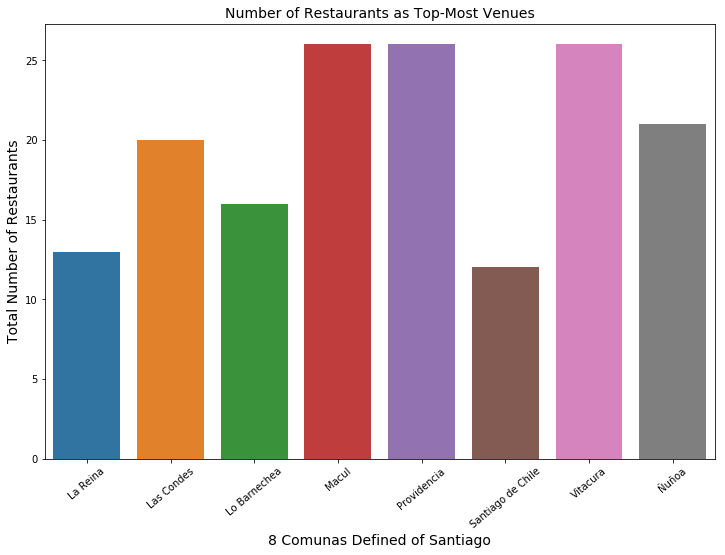

In [62]:
#try groupby to play with restaurant 
Santiago_8_Comunas_Venues_restaurant = Santiago_8_Comunas_Venues.groupby(['Comuna'])['Venue_Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
Santiago_8_Comunas_Venues_restaurant_df = Santiago_8_Comunas_Venues_restaurant.to_frame().reset_index()
Santiago_8_Comunas_Venues_restaurant_df.columns = ['Comuna', 'Number of Restaurant']

Santiago_8_Comunas_Venues_restaurant_df.index = np.arange(1, len(Santiago_8_Comunas_Venues_restaurant_df)+1)

list_rest_no = Santiago_8_Comunas_Venues_restaurant_df['Number of Restaurant'].to_list()
print (list_rest_no)
fig = plt.figure(figsize=(12,8))
bar = sns.barplot(x='Comuna', y='Number of Restaurant', data=Santiago_8_Comunas_Venues_restaurant_df)

bar.set_ylabel("Total Number of Restaurants", fontsize=14)
bar.set_xlabel("8 Comunas Defined of Santiago", fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(),rotation=40)
bar.set_title("Number of Restaurants as Top-Most Venues", fontsize=14)
plt.show()



In [63]:
# set number of clusters
kclusters = 3

Santiago_grouped_clustering = Santiago_8_Comunas_Venues_Grouped.drop('Comuna', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Santiago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print ("Check the 8 Cluster labels :",  kmeans.labels_[0:8])



Check the 8 Cluster labels : [3 0 2 1 0 0 2 0]


In [88]:
# add clustering labels

Comunas_top10_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

Santiago_8_Comuna_Coordinate_Cluster_merged = df_final
Santiago_8_Comuna_Coordinate_Cluster_merged.insert(0, 'Cluster Label', kmeans.labels_)

#merge the initial Comunas Dataframe with Sorted Most Visited places for each Comuna

Santiago_8_Comuna_Coordinate_Cluster_merged = pd.merge(Santiago_8_Comuna_Coordinate_Cluster_merged, Comunas_top10_venues_sorted, on='Comuna', how='inner')
Santiago_8_Comuna_Coordinate_Cluster_merged



,Cluster Label_x,Comuna,Population_2017,Houses,Population_growth,ICVU_index,Poberty,Square_KM2,Radius,Address,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Vitacura,85384,23878,6.2%,75.59,2.8,28.3,3001,"Vitacura, CL",...,Café,Park,Hotel,Gym / Fitness Center,Bakery,Restaurant,Italian Restaurant,Seafood Restaurant,Gym,Coffee Shop
1,0,Las Condes,294838,82099,19.6%,74.54,4.8,99.0,5613,"Las Condes, CL",...,Park,Bakery,Coffee Shop,Hotel,Peruvian Restaurant,Scenic Lookout,Ice Cream Shop,Japanese Restaurant,Mediterranean Restaurant,Liquor Store
2,2,La Reina,92787,25768,-3.8%,70.45,9.8,23.0,2705,"La Reina, CL",...,Soccer Field,Restaurant,Park,Pizza Place,Coffee Shop,Plaza,Pet Store,Farmers Market,Sushi Restaurant,Racetrack
3,1,Lo Barnechea,105833,16124,"43,2%",69.09,17.3,1024.0,9027,"Lo Barnechea, CL",...,Bakery,Coffee Shop,Shopping Mall,Gym,Park,Supermarket,Motorcycle Shop,Trail,Golf Course,Gym / Fitness Center
4,0,Providencia,142079,51183,21.4%,68.79,4.6,14.3,2133,"Providencia, CL",...,Coffee Shop,Hotel,Park,French Restaurant,Indian Restaurant,Ice Cream Shop,Bakery,Café,Scenic Lookout,Restaurant
5,0,Ñuñoa,208237,54692,28.2%,66.28,10.7,16.9,2319,"Ñuñoa, CL",...,Coffee Shop,Bakery,Peruvian Restaurant,Pizza Place,Plaza,Restaurant,Italian Restaurant,Sandwich Place,Café,Park
6,2,Macul,116534,29870,4.1%,61.92,17.5,12.9,2026,"Macul, CL",...,Chinese Restaurant,Restaurant,Soccer Field,Pharmacy,Hot Dog Joint,Sushi Restaurant,Pizza Place,Sandwich Place,Food Truck,BBQ Joint
7,0,Santiago de Chile,404495,99155,88.9%,59.27,11.6,23.2,2717,"Santiago de Chile, CL",...,Coffee Shop,Café,Park,Pizza Place,Theater,Hotel,Sushi Restaurant,Bookstore,Plaza,Scenic Lookout


In [91]:
# create map
map_clusters = folium.Map(location=[Santiago_latitude, Santiago_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Santiago_8_Comuna_Coordinate_Cluster_merged['Latitude'], 
                                  Santiago_8_Comuna_Coordinate_Cluster_merged['Longitude'], 
                                  Santiago_8_Comuna_Coordinate_Cluster_merged['Comuna'], 
                                  Santiago_8_Comuna_Coordinate_Cluster_merged['Cluster Label_x']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [94]:
Santiago_Cluster1 = Santiago_8_Comuna_Coordinate_Cluster_merged.loc[Santiago_8_Comuna_Coordinate_Cluster_merged['Cluster Label_x'] == 0, 
                                    Santiago_8_Comuna_Coordinate_Cluster_merged.columns[[3] + list(range(4, Santiago_8_Comuna_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 0: %d" %(Santiago_Cluster1.shape[0]))
Santiago_Cluster1

No of Neighbourhood in Cluster Label 0: 4


,Houses,Population_growth,ICVU_index,Poberty,Square_KM2,Radius,Address,Latitude,Longitude,Cluster Label_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,82099,19.6%,74.54,4.8,99.0,5613,"Las Condes, CL",-33.416667,-70.600000,0,Park,Bakery,Coffee Shop,Hotel,Peruvian Restaurant,Scenic Lookout,Ice Cream Shop,Japanese Restaurant,Mediterranean Restaurant,Liquor Store
4,51183,21.4%,68.79,4.6,14.3,2133,"Providencia, CL",-33.428838,-70.611337,0,Coffee Shop,Hotel,Park,French Restaurant,Indian Restaurant,Ice Cream Shop,Bakery,Café,Scenic Lookout,Restaurant
5,54692,28.2%,66.28,10.7,16.9,2319,"Ñuñoa, CL",-33.454330,-70.600582,0,Coffee Shop,Bakery,Peruvian Restaurant,Pizza Place,Plaza,Restaurant,Italian Restaurant,Sandwich Place,Café,Park
7,99155,88.9%,59.27,11.6,23.2,2717,"Santiago de Chile, CL",-33.437797,-70.650445,0,Coffee Shop,Café,Park,Pizza Place,Theater,Hotel,Sushi Restaurant,Bookstore,Plaza,Scenic Lookout


In [96]:
Santiago_Cluster2 = Santiago_8_Comuna_Coordinate_Cluster_merged.loc[Santiago_8_Comuna_Coordinate_Cluster_merged['Cluster Label_x'] == 1, 
                                    Santiago_8_Comuna_Coordinate_Cluster_merged.columns[[3] + list(range(4, Santiago_8_Comuna_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 1: %d" %(Santiago_Cluster2.shape[0]))
Santiago_Cluster2

No of Neighbourhood in Cluster Label 1: 1


,Houses,Population_growth,ICVU_index,Poberty,Square_KM2,Radius,Address,Latitude,Longitude,Cluster Label_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,16124,"43,2%",69.09,17.3,1024.0,9027,"Lo Barnechea, CL",-33.35,-70.516667,2,Bakery,Coffee Shop,Shopping Mall,Gym,Park,Supermarket,Motorcycle Shop,Trail,Golf Course,Gym / Fitness Center


In [97]:
Santiago_Cluster3 = Santiago_8_Comuna_Coordinate_Cluster_merged.loc[Santiago_8_Comuna_Coordinate_Cluster_merged['Cluster Label_x'] == 2, 
                                    Santiago_8_Comuna_Coordinate_Cluster_merged.columns[[3] + list(range(4, Santiago_8_Comuna_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 2: %d" %(Santiago_Cluster3.shape[0]))
Santiago_Cluster3

No of Neighbourhood in Cluster Label 2: 2


,Houses,Population_growth,ICVU_index,Poberty,Square_KM2,Radius,Address,Latitude,Longitude,Cluster Label_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,25768,-3.8%,70.45,9.8,23.0,2705,"La Reina, CL",-33.447373,-70.533412,3,Soccer Field,Restaurant,Park,Pizza Place,Coffee Shop,Plaza,Pet Store,Farmers Market,Sushi Restaurant,Racetrack
6,29870,4.1%,61.92,17.5,12.9,2026,"Macul, CL",-33.491943,-70.599732,1,Chinese Restaurant,Restaurant,Soccer Field,Pharmacy,Hot Dog Joint,Sushi Restaurant,Pizza Place,Sandwich Place,Food Truck,BBQ Joint


In [98]:
Santiago_Cluster4 = Santiago_8_Comuna_Coordinate_Cluster_merged.loc[Santiago_8_Comuna_Coordinate_Cluster_merged['Cluster Label_x'] == 3, 
                                    Santiago_8_Comuna_Coordinate_Cluster_merged.columns[[3] + list(range(4, Santiago_8_Comuna_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 3: %d" %(Santiago_Cluster4.shape[0]))
Santiago_Cluster4

No of Neighbourhood in Cluster Label 3: 1


,Houses,Population_growth,ICVU_index,Poberty,Square_KM2,Radius,Address,Latitude,Longitude,Cluster Label_y,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,23878,6.2%,75.59,2.8,28.3,3001,"Vitacura, CL",-33.380206,-70.565796,2,Café,Park,Hotel,Gym / Fitness Center,Bakery,Restaurant,Italian Restaurant,Seafood Restaurant,Gym,Coffee Shop
